In [1]:
import videoReplayFast

In [2]:
gen = videoReplayFast.threadedProvide()

In [3]:
q = next(gen)

Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file
Error opening video  file


In [4]:
import tensorflow as tf
import numpy as np

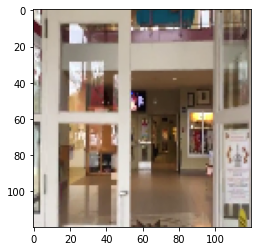

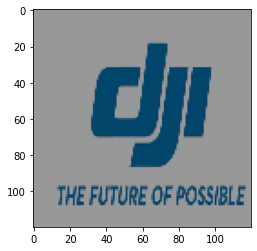

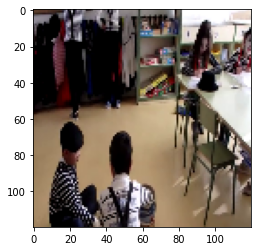

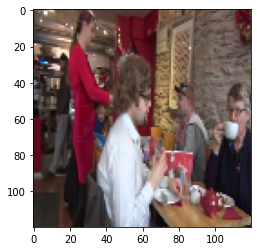

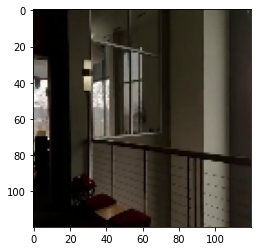

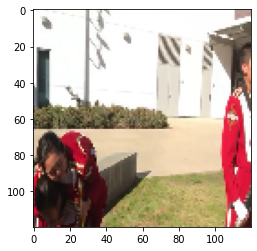

In [5]:
def training_generator():
    while True:
        inp = next(gen).numpy().astype(np.float32) / 255.
        yield (inp[:, :, :, [2, 1, 0]], inp[:, :, :, [6, 5, 4]]), inp[:, :, :, [6, 5, 4]]

import matplotlib.pyplot as plt
for _ in range(6):
    plt.imshow(next(training_generator())[0][0][0])
    plt.show()

In [6]:
import numpy as np

In [7]:
import tensorflow as tf

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

2021-09-17 14:13:38.097592: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-17 14:13:42.145958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46729 MB memory:  -> device: 0, name: RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2021-09-17 14:13:42.153548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46729 MB memory:  -> device: 1, name: RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2021-09-17 14:13:42.158196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Running on multiple GPUs  ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']
Number of accelerators:  4


In [8]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.001
LEARNING_RATE_EXP_DECAY = 1# = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

SCALE = 1
SIDE_LENGTH = 90





In [9]:
q = training_generator()


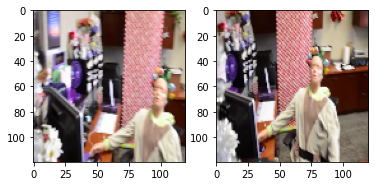

In [10]:
import matplotlib.pyplot as plt
a = next(q)
plt.subplot(1, 2, 1)
plt.imshow(a[0][0][60])
plt.subplot(1, 2, 2)
plt.imshow(a[0][1][60])

In [11]:
FEATURE_LENGTH = 128

def make_model():
    model = tf.keras.Sequential(
      [
        
        #tf.keras.layers.ZeroPadding2D(padding=(15, 15), input_shape=(SIDE_LENGTH, SIDE_LENGTH, 1)),
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=128, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=256, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
       
        tf.keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm
       
        tf.keras.layers.Conv2D(filters=128, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        #tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        #tf.keras.layers.Activation('relu'), # activation after batch norm
      ])
    
    input_A = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    input_B = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    features_A = model(input_A)
    features_B = model(input_B)

    features_A = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, FEATURE_LENGTH))(features_A)
    features_B = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, FEATURE_LENGTH))(features_B)

    cc = tf.keras.layers.Lambda(lambda var: tf.linalg.matmul(var[0], var[1], transpose_b=True), name="matmul")([features_A, features_B])

    cc_A = tf.keras.layers.Softmax(axis=-1)(cc)
    cc_B = tf.keras.layers.Softmax(axis=-2)(cc)

    loss = tf.keras.layers.Multiply()([cc_A, cc_B])
    
    loss = tf.keras.layers.Lambda(lambda var: tf.math.reduce_sum(var, axis=-1))(loss)


    loss = tf.keras.layers.Lambda(lambda var: tf.clip_by_value(var, 0, .8), name="clip")(loss)

    def fmapICON_clamp_loss(tensor, nonsense):
    
      return -tf.math.reduce_sum(nonsense) / BATCH_SIZE / SIDE_LENGTH / SIDE_LENGTH * strategy.num_replicas_in_sync

    outer_model = tf.keras.Model(inputs=(input_A, input_B), outputs=loss)

    outer_model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss=fmapICON_clamp_loss)
    return outer_model
    
with strategy.scope():
    model = make_model()
# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

class SaveWeightsCallback(tf.keras.callbacks.Callback):
    

    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("correct_clip.8_model_weights.tf")
        

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
EPOCHS = 60
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
  
history = model.fit(training_generator(),
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    callbacks=[lr_decay, SaveWeightsCallback()])

final_stats = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", final_stats[1])

Steps per epoch:  937


2021-09-17 14:13:47.742246: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1343"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        di

Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1


2021-09-17 14:13:59.072136: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-09-17 14:14:01.316007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-09-17 14:14:02.924166: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-09-17 14:14:04.364981: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-09-17 14:14:07.685787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


 23/937 [..............................] - ETA: 13:54 - loss: -0.1291

[matroska,webm @ 0x556baee13a80] EBML header parsing failed


 75/937 [=>............................] - ETA: 13:06 - loss: -0.2913

[matroska,webm @ 0x556bae871800] EBML header parsing failed


937/937 [==============================] - 882s 903ms/step - loss: -0.4482
Epoch 2/60

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 840s 897ms/step - loss: -0.4938
Epoch 3/60

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 842s 898ms/step - loss: -0.5113
Epoch 4/60

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
750/937 [=======================>......] - ETA: 2:47 - loss: -0.5127

[matroska,webm @ 0x556baef04600] EBML header parsing failed


927/937 [============================>.] - ETA: 9s - loss: -0.5137

[matroska,webm @ 0x556baef04600] EBML header parsing failed


937/937 [==============================] - 844s 901ms/step - loss: -0.5138
Epoch 5/60

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 838s 894ms/step - loss: -0.5243
Epoch 6/60

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
354/937 [==========>...................] - ETA: 8:51 - loss: -0.5236

[matroska,webm @ 0x556baeaebb80] EBML header parsing failed


937/937 [==============================] - 846s 903ms/step - loss: -0.5242
Epoch 7/60

Epoch 00007: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 837s 894ms/step - loss: -0.5196
Epoch 8/60

Epoch 00008: LearningRateScheduler setting learning rate to 0.001.
843/937 [=========================>....] - ETA: 1:24 - loss: -0.5236

[matroska,webm @ 0x556baeb196c0] EBML header parsing failed


937/937 [==============================] - 845s 902ms/step - loss: -0.5242
Epoch 9/60

Epoch 00009: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 840s 896ms/step - loss: -0.5279
Epoch 10/60

Epoch 00010: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 842s 899ms/step - loss: -0.5286
Epoch 11/60

Epoch 00011: LearningRateScheduler setting learning rate to 0.001.
470/937 [==============>...............] - ETA: 7:01 - loss: -0.5285

[matroska,webm @ 0x556bae0ea240] EBML header parsing failed


937/937 [==============================] - 842s 898ms/step - loss: -0.5298
Epoch 12/60

Epoch 00012: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 840s 897ms/step - loss: -0.5322
Epoch 13/60

Epoch 00013: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 844s 901ms/step - loss: -0.5367
Epoch 14/60

Epoch 00014: LearningRateScheduler setting learning rate to 0.001.
488/937 [==============>...............] - ETA: 6:41 - loss: -0.5384

[matroska,webm @ 0x556bae4c1040] EBML header parsing failed


583/937 [=================>............] - ETA: 5:17 - loss: -0.5374

[matroska,webm @ 0x556baeecbe80] EBML header parsing failed


678/937 [====================>.........] - ETA: 3:52 - loss: -0.5365

[matroska,webm @ 0x556baea1db80] EBML header parsing failed


937/937 [==============================] - 838s 894ms/step - loss: -0.5357
Epoch 15/60

Epoch 00015: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 846s 903ms/step - loss: -0.5338
Epoch 16/60

Epoch 00016: LearningRateScheduler setting learning rate to 0.001.
336/937 [=========>....................] - ETA: 8:53 - loss: -0.5362

[matroska,webm @ 0x556bae93b180] EBML header parsing failed


937/937 [==============================] - 838s 895ms/step - loss: -0.5370
Epoch 17/60

Epoch 00017: LearningRateScheduler setting learning rate to 0.001.
411/937 [============>.................] - ETA: 7:53 - loss: -0.5307

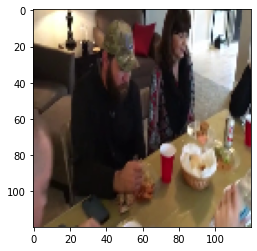

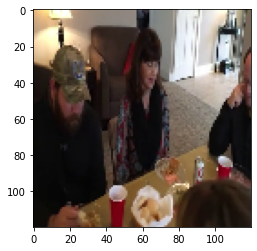

In [19]:
(A, B), Q = a
A = A[40:]
B = B[40:]
plt.imshow(A[0])
plt.show()
plt.imshow(B[0])
plt.show()

In [20]:
x = model((A[:3], B[:3]))

2021-09-17 10:41:47.380468: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [21]:
plt.figure(figsize=(40, 40))
plt.imshow(x[2, :2000, :2000])

2021-09-17 10:41:49.855428: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at strided_slice_op.cc:108 : Invalid argument: Index out of range using input dim 2; input has only 2 dims


InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

<Figure size 2880x2880 with 0 Axes>

In [22]:
inner_model = model.layers[2]

In [51]:
F_A = tf.reshape(inner_model(A)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
F_B = tf.reshape(inner_model(B)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
cc = tf.linalg.matmul(F_A, F_B, transpose_b=True)
#cc = tf.nn.softmax(cc, axis=-1)
cc = tf.reshape(cc, [10] + [SIDE_LENGTH] * 4)
cc = np.array(cc)

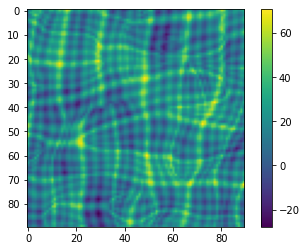

In [52]:
plt.imshow(cc[3, 45, 68])
plt.colorbar()

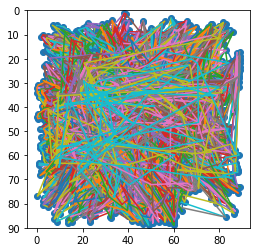

In [25]:
plt.figure(figsize=(4, 4))
import scipy.ndimage
grid = np.array(
  [
    [
        [
            scipy.ndimage.measurements.center_of_mass(cc[k, i, j].transpose())
            for i in range(SIDE_LENGTH)
        ]
        for j in range(SIDE_LENGTH)
    ]
   for k in range(10)]
)
#grid[:, :, 0] = scipy.ndimage.gaussian_filter(grid[:, :, 0], 1)
#grid[:, :, 1] = scipy.ndimage.gaussian_filter(grid[:, :, 1], 1)

#grid = grid[3:-3, 3:-3]

plt.plot(grid[0, :, :, 0], grid[0, :, :, 1])
plt.plot(grid[0, :, :, 0].transpose(), grid[0, :, :, 1].transpose())
plt.ylim(SIDE_LENGTH, 0)

plt.scatter(grid[0, :, :, 0], grid[0, :, :, 1])

plt.ylim(SIDE_LENGTH, 0)
plt.show()

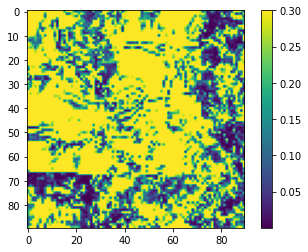

In [40]:
plt.imshow(tf.reshape(x[1], (SIDE_LENGTH, SIDE_LENGTH)))
plt.colorbar()



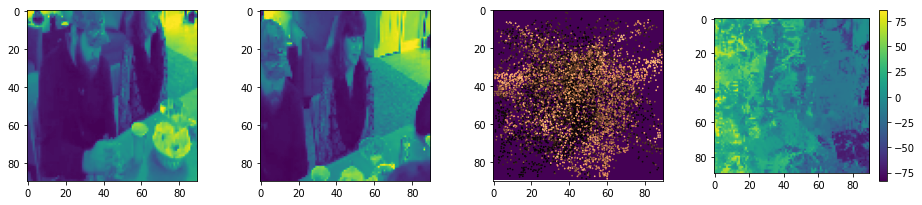

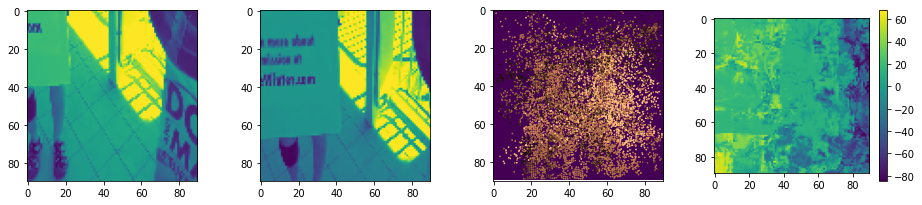

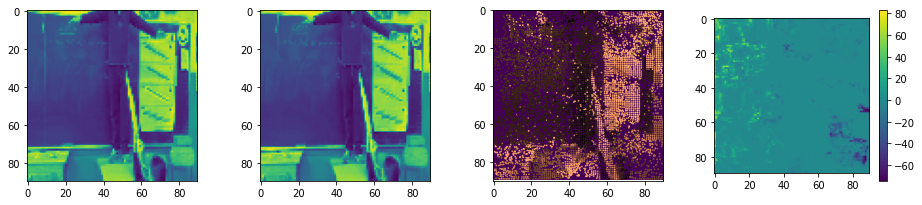

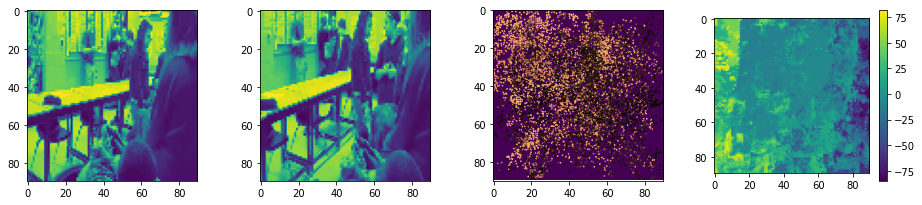

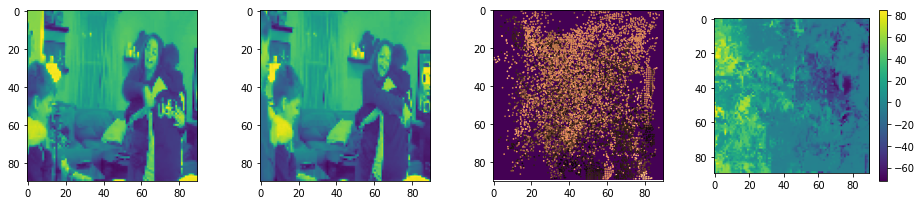

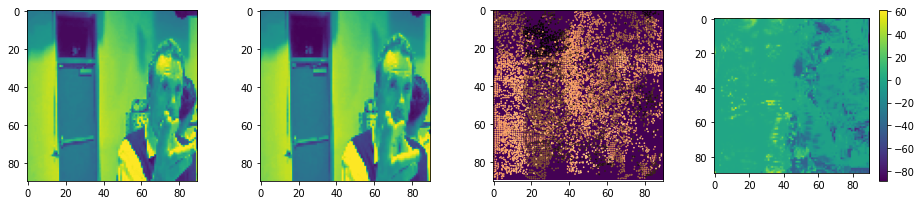

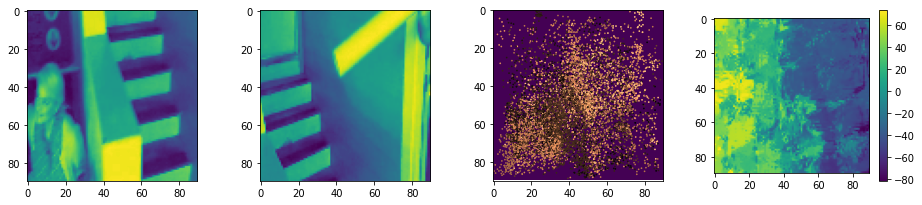

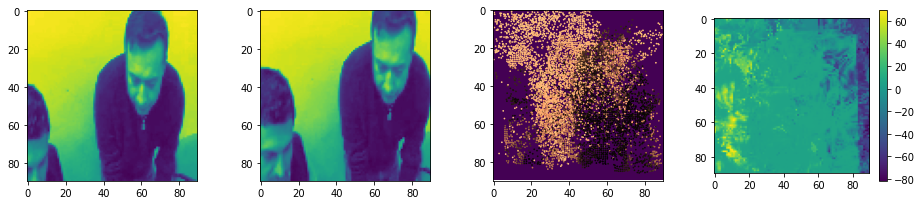

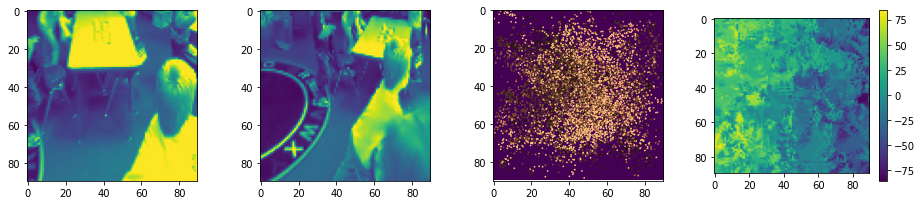

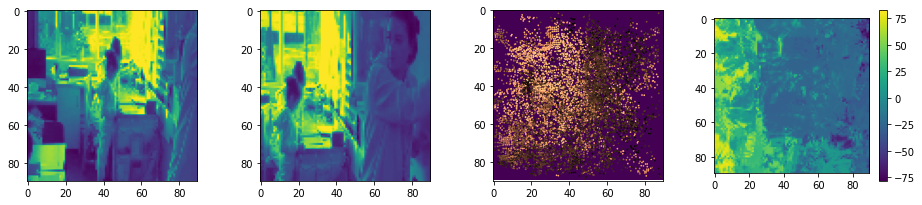

In [39]:
for k in range(10):
    plt.figure(figsize=(16, 37))
    plt.subplot(10, 4, 1)
    plt.imshow(A[k, 15:-15, 15:-15, 0])
    plt.subplot(10, 4, 2)
    plt.imshow(B[k, 15:-15, 15:-15, 0])
    plt.subplot(10, 4, 3)
    plt.ylim(SIDE_LENGTH, 0)
    plt.imshow(B[k, 15:-15, 15:-15, 0] * 0)
    plt.scatter(grid[k, :, :, 0], grid[k, :, :, 1], c=np.array(A)[k, 15:-15, 15:-15, 0].transpose(), cmap="copper", s=.5)
    plt.subplot(10, 4, 4)
    g = grid[k].transpose(1, 0, 2)
    plt.imshow(g[:, :, 0] - np.expand_dims(np.arange(90), 0))
    plt.colorbar()

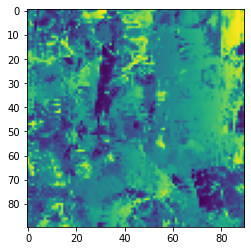

In [28]:
g = grid[0].transpose(1, 0, 2)
plt.imshow(g[:, :, 0])

In [29]:
f_a = np.array(F_A)#.reshape(90, 90, 128)
f_b = np.array(F_B)#.reshape(90, 90, 128)

In [30]:
f_a = f_a.reshape(-1, 128)
f_b = f_b.reshape(-1, 128)

In [31]:

from sklearn import decomposition
pca = decomposition.PCA(n_components=30)

x_a = pca.fit_transform(f_a)
x_b = pca.fit_transform(f_b)

In [32]:
x.shape

TensorShape([3, 8100])

In [33]:
x_a = x_a.reshape(10, 90, 90, 30)
x_b = x_b.reshape(10, 90, 90, 30)

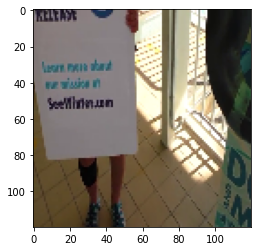

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


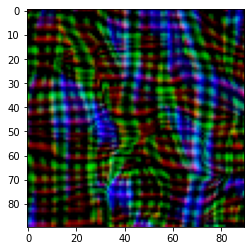

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


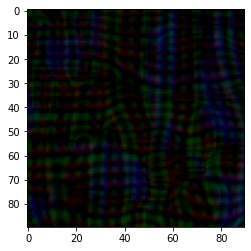

In [34]:
dd = 0
dd += 1
dd %= 10
plt.imshow(B[dd])
plt.show()
plt.imshow(f_a.reshape(10, 90, 90, 128)[dd, :, :, 0:3] / 2)
plt.show()
plt.imshow(f_b.reshape(10, 90, 90, 128)[dd, :, :, 0:3] / 8)

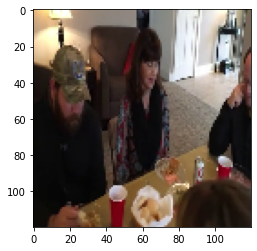

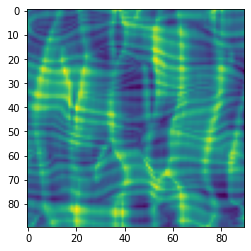

TypeError: Invalid shape (10, 90, 90, 128) for image data

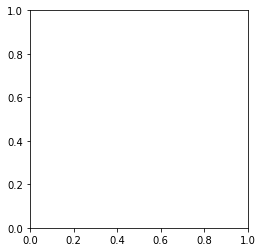

In [35]:
dd = 0
#dd += 1
#dd %= 10
plt.imshow(B[dd])
plt.show()
plt.imshow(np.sum(f_a.reshape(10, 90, 90, 128), axis=-1)[dd])
plt.show()
plt.imshow(f_b.reshape(10, 90, 90, 128))

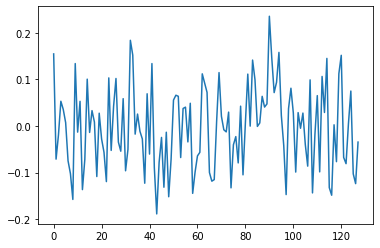

In [84]:
plt.plot(pca.components_[0])

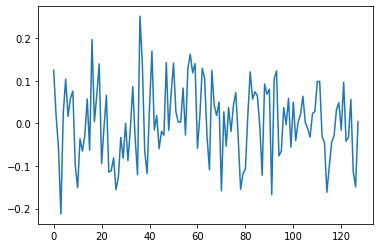

In [162]:
plt.plot(pca.components_[0])

In [44]:
w = model.get_weights()

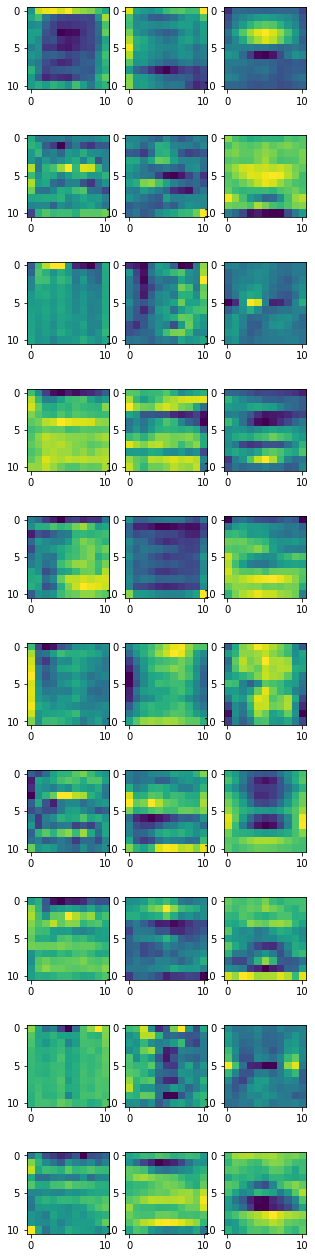

In [45]:
plt.figure(figsize=(5, 23))
for i in range(3):
    for j in range(10):
        plt.subplot(10, 3, 3 * j + i + 1)
        plt.imshow(w[8][:, :, i, j + 10])

In [79]:
model.save("longtrain_longgap")
model.save_weights("longtrain_longgap_w")

2021-09-07 17:22:14.744193: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: longtrain_longgap/assets


/playpen-raid1/tgreer/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [39]:
gen.gi_frame.f_locals

AttributeError: 'NoneType' object has no attribute 'f_locals'

In [37]:
history.history

{'loss': [-0.1973511427640915,
  -0.21709825098514557,
  -0.21913526952266693,
  -0.2218404859304428,
  -0.22315068542957306,
  -0.22497065365314484,
  -0.22636963427066803,
  -0.2262074500322342,
  -0.22796045243740082,
  -0.22784319519996643,
  -0.22844377160072327,
  -0.22784365713596344,
  -0.22901387512683868,
  -0.22790472209453583,
  -0.23011957108974457,
  -0.2292814999818802,
  -0.22883261740207672,
  -0.22883956134319305,
  -0.22999359667301178,
  -0.23103895783424377,
  -0.2286560982465744,
  -0.22919124364852905,
  -0.2290077805519104,
  -0.22972778975963593,
  -0.23033791780471802,
  -0.22945362329483032,
  -0.22901612520217896,
  -0.2308814376592636,
  -0.23026423156261444,
  -0.23103539645671844,
  -0.22987410426139832,
  -0.23002392053604126,
  -0.23071464896202087,
  -0.2314862459897995,
  -0.22997403144836426,
  -0.23121696710586548,
  -0.23026271164417267,
  -0.23142366111278534,
  -0.23106998205184937,
  -0.23084813356399536,
  -0.23178236186504364,
  -0.23120120167

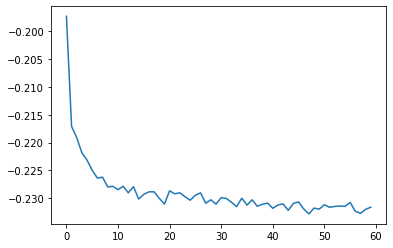

In [38]:
plt.plot(history.history['loss'])